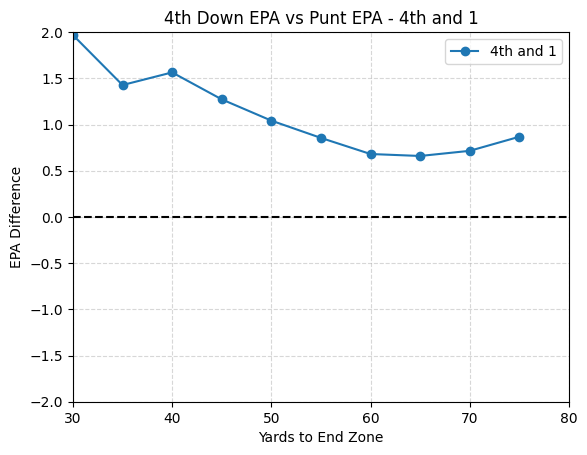

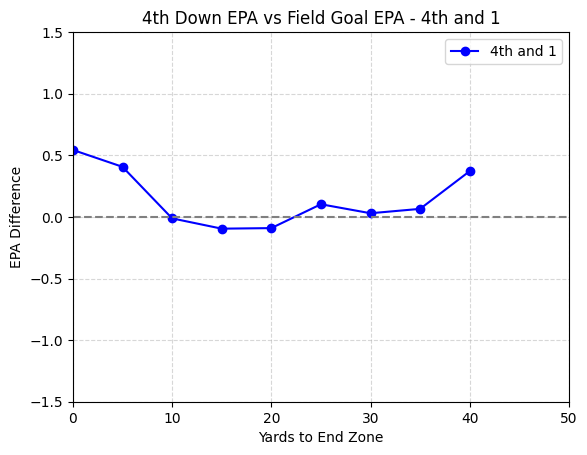

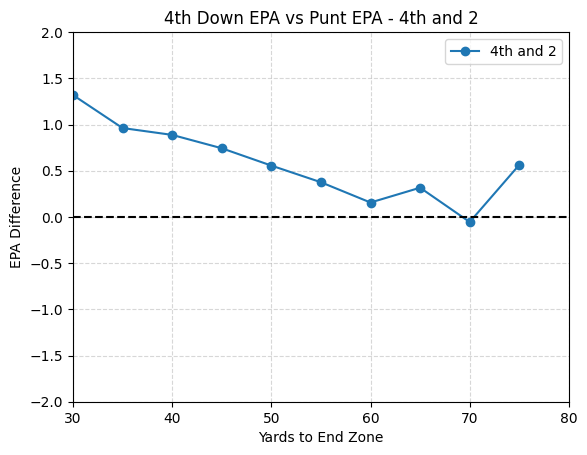

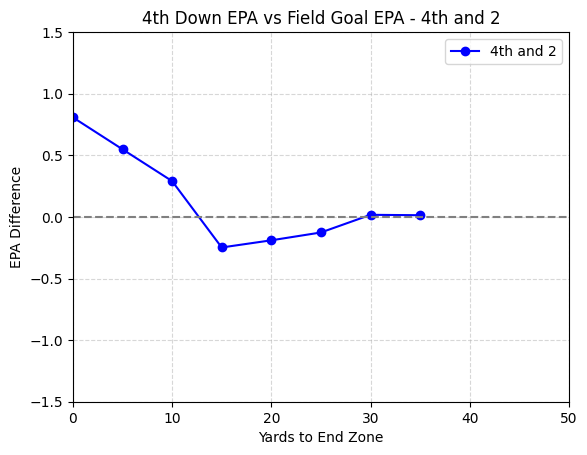

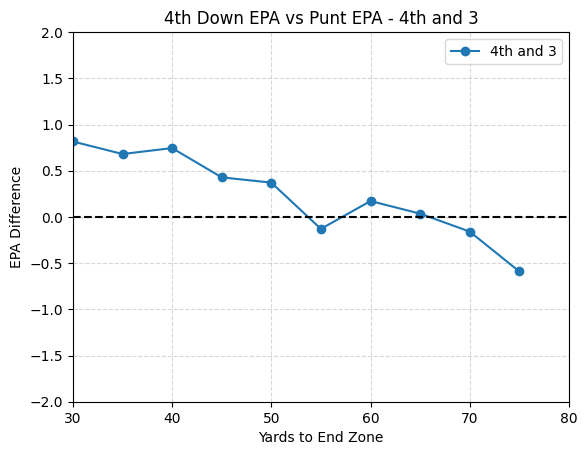

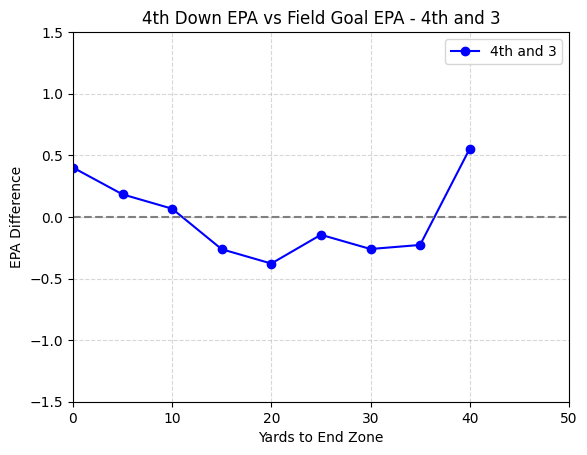

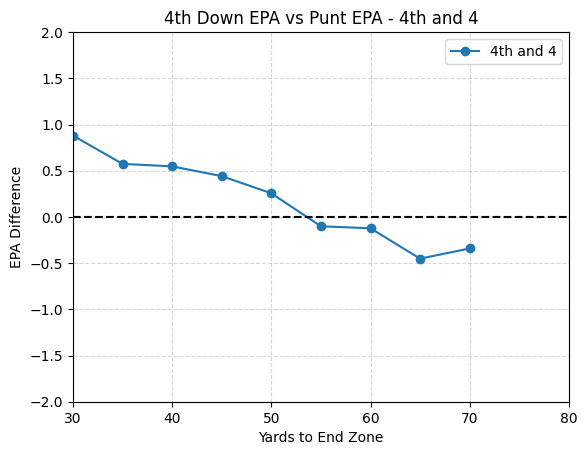

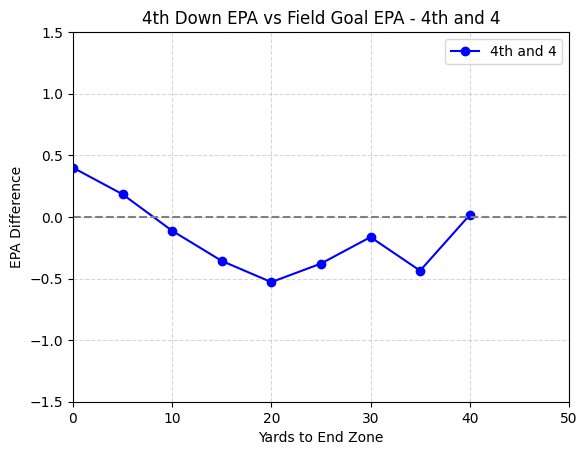

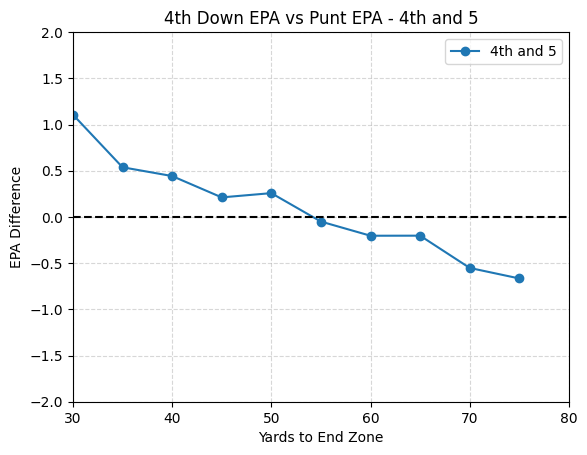

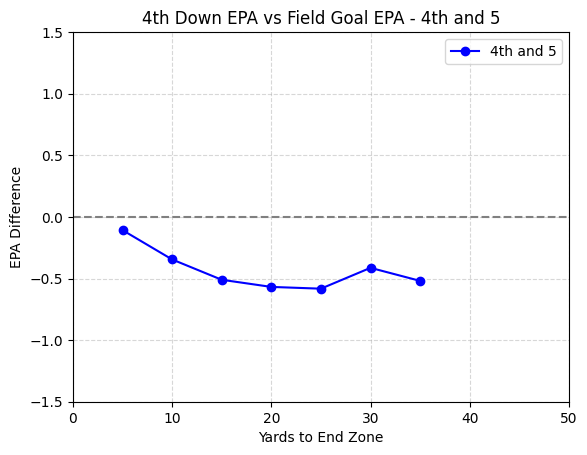

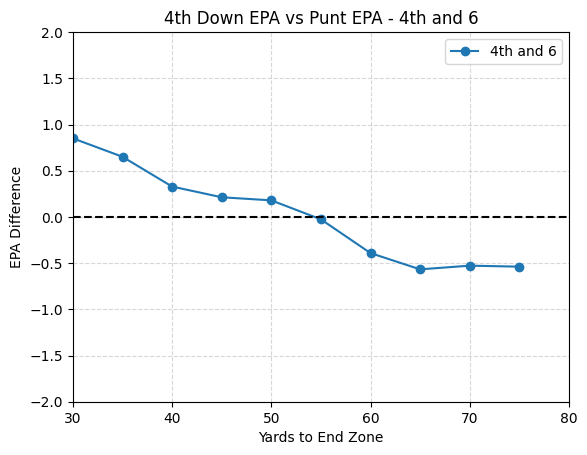

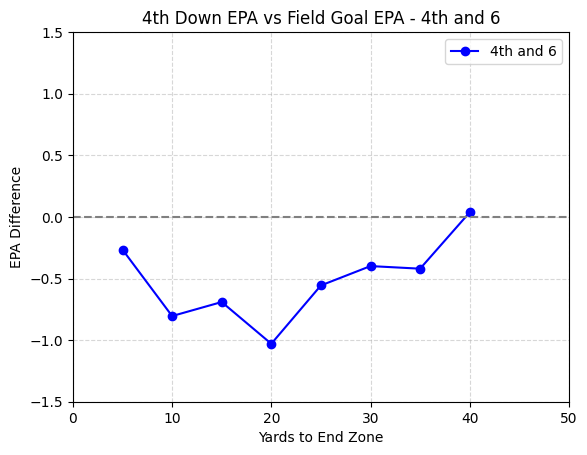

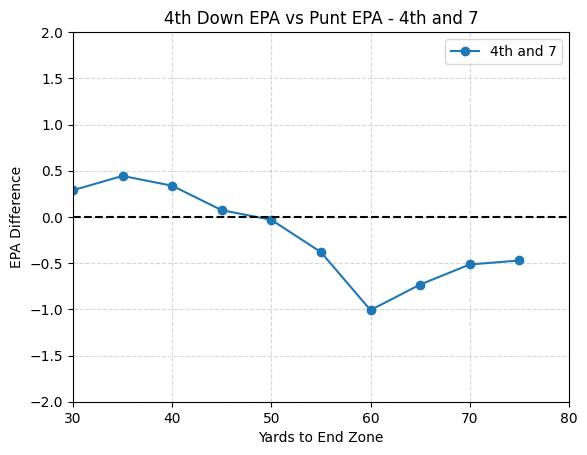

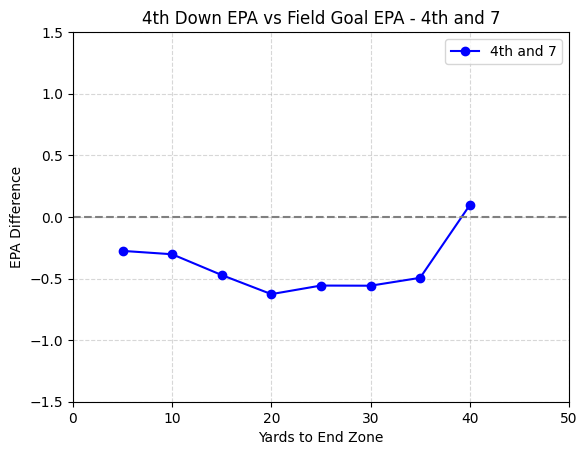

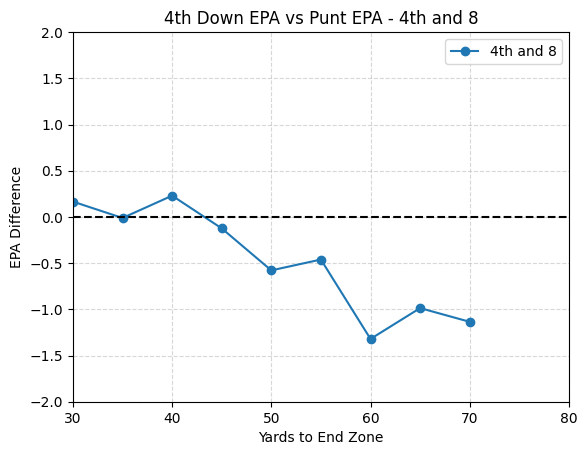

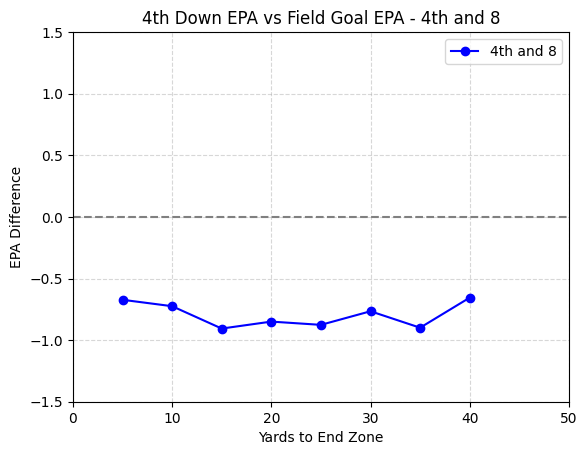

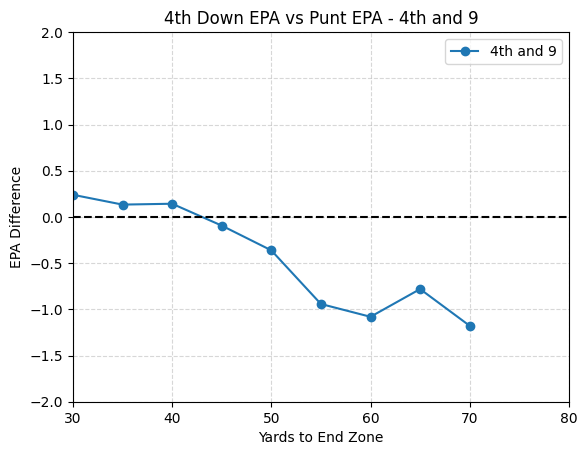

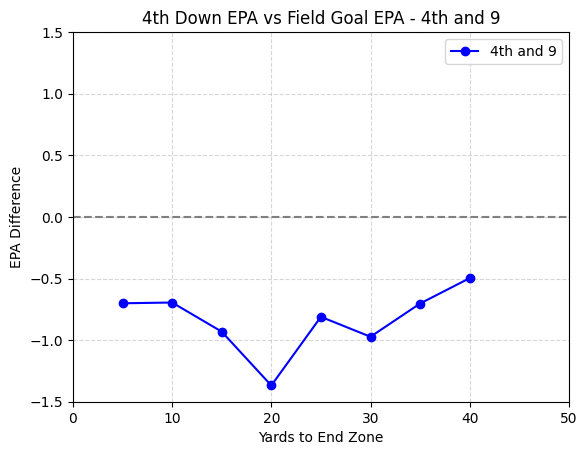

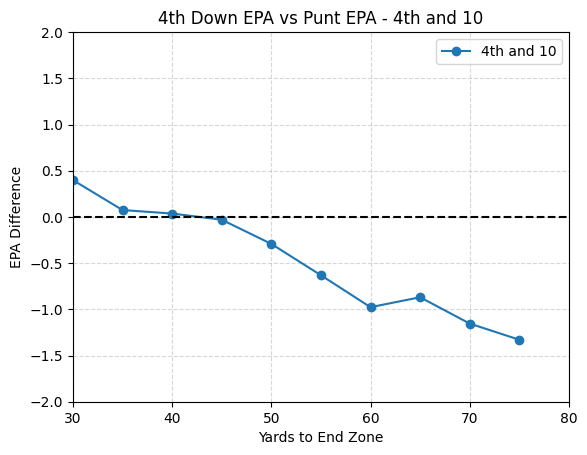

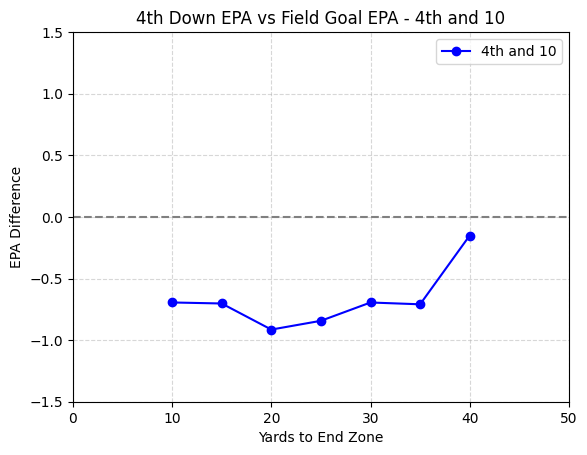

In [2]:
import pandas as pd
import nfl_data_py as nfl
import matplotlib.pyplot as plt
import numpy as np

# Load data (choose method based on availability)
try:
    df = pd.read_csv("pbp2.csv", index_col=0, na_values=["", "NA"], low_memory=False)
except FileNotFoundError:
    df = nfl.import_pbp_data(
        years=list(range(1999, 2020)) + list(range(2021, 2025)),
        downcast=True,
        cache=False
    )

# Filter for 4th down plays and relevant EPA/yards
df = df[(df.down == 4) & df.epa.notna()]
df = df[(df['epa'] >= -5) & (df['epa'] <= 5)]
df = df[df['yardline_100'] <= 75]

# Function to subset data by ydstogo and play type
def get_filtered_data(df, ydstogo):
    subset = df[df.ydstogo == ydstogo]
    return {
        'pass_run': subset[subset['play_type'].isin(['pass', 'run'])],
        'punt': subset[subset['play_type'] == 'punt'],
        'field_goal': subset[subset['play_type'] == 'field_goal']
    }

# Plotting function for conversion vs punt
def conversion_vs_punt(pass_run_df, punt_df, title, yard_bin=5):
    pass_run_df['yard_bin'] = (pass_run_df['yardline_100'] // yard_bin) * yard_bin
    punt_df['yard_bin'] = (punt_df['yardline_100'] // yard_bin) * yard_bin

    pos = pass_run_df[pass_run_df.epa > 0].groupby('yard_bin')['epa'].mean()
    neg = pass_run_df[pass_run_df.epa < 0].groupby('yard_bin')['epa'].mean()
    punt_epa = punt_df.groupby('yard_bin')['epa'].mean()

    converted = pass_run_df['fourth_down_converted'].sum()
    failed = pass_run_df['fourth_down_failed'].sum()
    rate = converted / (converted + failed)

    epa_diff = pos * rate + neg * (1 - rate)
    result = epa_diff - punt_epa

    plt.plot(result.index, result, marker='o', linestyle='-', label=title)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title(f'4th Down EPA vs Punt EPA - {title}')
    plt.xlabel('Yards to End Zone')
    plt.ylabel('EPA Difference')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.ylim(-2, 2)
    plt.xlim(30, 80)
    plt.legend()
    plt.show()

# Plotting function for conversion vs field goal
def conversion_vs_fg(pass_run_df, fg_df, full_fg, title):
    max_kick = fg_df['yardline_100'].max()
    pass_run_df = pass_run_df[pass_run_df['yardline_100'] <= max_kick]

    pass_run_df = pass_run_df.copy()
    fg_df = fg_df.copy()
    full_fg = full_fg.copy()

    pass_run_df['yard_bin'] = (pass_run_df['yardline_100'] // 5) * 5
    fg_df['yard_bin'] = (fg_df['yardline_100'] // 5) * 5
    full_fg['yard_bin'] = (full_fg['yardline_100'] // 5) * 5

    conv = pass_run_df['fourth_down_converted'].sum()
    fail = pass_run_df['fourth_down_failed'].sum()
    rate = conv / (conv + fail) if (conv + fail) > 0 else 0

    pos = pass_run_df[pass_run_df.epa > 0].groupby('yard_bin')['epa'].mean()
    neg = pass_run_df[pass_run_df.epa < 0].groupby('yard_bin')['epa'].mean()
    epa_diff = pos * rate + neg * (1 - rate)

    fg_pos = fg_df[fg_df.epa > 0].groupby('yard_bin')['epa'].mean()
    fg_neg = fg_df[fg_df.epa < 0].groupby('yard_bin')['epa'].mean()
    fg_rates = (full_fg[full_fg.field_goal_result == 'made'].groupby('yard_bin').size()
                / full_fg.groupby('yard_bin').size()).fillna(0)
    fg_epa = fg_pos * fg_rates + fg_neg * (1 - fg_rates)

    result = epa_diff - fg_epa

    plt.plot(result.index, result, marker='o', linestyle='-', color='blue', label=title)
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.title(f'4th Down EPA vs Field Goal EPA - {title}')
    plt.xlabel('Yards to End Zone')
    plt.ylabel('EPA Difference')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.ylim(-1.5, 1.5)
    plt.xlim(0, 50)
    plt.legend()
    plt.show()

# Run plots for 4th and 1 through 10
full_fg = df[df.play_type == 'field_goal']
for ydstogo in range(1, 11):
    data = get_filtered_data(df, ydstogo)
    conversion_vs_punt(data['pass_run'], data['punt'], f"4th and {ydstogo}")
    conversion_vs_fg(data['pass_run'], data['field_goal'], full_fg, f"4th and {ydstogo}")
